# Exercício 9

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.python.util.deprecation as deprecation
import tensorflow.compat.v1 as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from datetime import datetime

In [2]:
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [4]:
reset_graph()

In [5]:
N = 1000

X, y = make_moons(N, noise=0.1, random_state=42)

In [6]:
# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

x_test_original = x_test

y_test_original = y_test

x_train = np.c_[np.ones((len(y_train), 1)), x_train, x_train**2, x_train**3]

x_test = np.c_[np.ones((len(y_test), 1)), x_test, x_test**2, x_test**3]

In [7]:
n_inputs = len(x_test[0])

learning_rate = 1

logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [8]:
initializer = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)
theta = tf.Variable(initializer, name="theta")
matmul = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(matmul)

In [9]:
loss = tf.losses.log_loss(y, y_proba, scope="loss")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
loss_summary = tf.summary.scalar('log_loss', loss)

In [10]:
init = tf.global_variables_initializer()

In [11]:
saver = tf.train.Saver()

In [12]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [13]:
n_epochs = 10001
minibatch_size = 50
n_batches = int(np.ceil(N / minibatch_size))

save_path = "/tmp/my_model.ckpt"
checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

save_interval = 500

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if there is a checkpoint file, restore model and load epoch
        with open(checkpoint_epoch_path, "rb") as f:
            initial_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", initial_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        # if there is no checkpoint file, epoch is equal to zero
        initial_epoch = 0
        sess.run(init)
        
    y_test = y_test.reshape(-1, 1)
    for epoch in range(initial_epoch, n_epochs):
    
        random_indices = np.random.randint(0, len(x_train), minibatch_size)
        X_batch = x_train[random_indices]
        y_batch = y_train[random_indices]
            
        y_batch = y_batch.reshape(-1, 1)
        
        for i in range(0, N, minibatch_size): 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: x_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % save_interval == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: x_test, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.26660535
Epoch: 500 	Loss: 0.0073265494
Epoch: 1000 	Loss: 0.005124873
Epoch: 1500 	Loss: 0.0039951676
Epoch: 2000 	Loss: 0.003491174
Epoch: 2500 	Loss: 0.0030083745
Epoch: 3000 	Loss: 0.0026678029
Epoch: 3500 	Loss: 0.0028917952
Epoch: 4000 	Loss: 0.001994246
Epoch: 4500 	Loss: 0.0018936103
Epoch: 5000 	Loss: 0.0029547228
Epoch: 5500 	Loss: 0.0018544336
Epoch: 6000 	Loss: 0.0018256106
Epoch: 6500 	Loss: 0.0014895939
Epoch: 7000 	Loss: 0.0016037301
Epoch: 7500 	Loss: 0.0011625972
Epoch: 8000 	Loss: 0.0010917276
Epoch: 8500 	Loss: 0.0011236842
Epoch: 9000 	Loss: 0.001027707
Epoch: 9500 	Loss: 0.0011896181
Epoch: 10000 	Loss: 0.0010239404


In [14]:
# if greater than 0.5 is classified as another class
y_pred = (y_proba_val >= 0.5)

In [15]:
print(precision_score(y_test, y_pred))

1.0


In [16]:
y_pred = y_pred.reshape(-1)

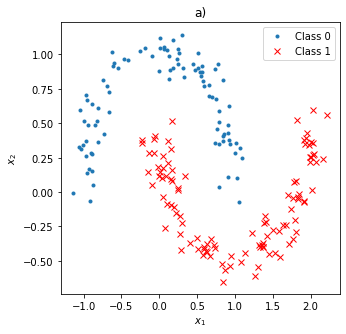

In [17]:
idx0 = np.argwhere(y_pred == False)
idx1 = np.argwhere(y_pred == True)

fig = plt.figure(figsize=(5,5))
plt.plot(x_test_original[idx0,0], x_test_original[idx0,1], '.', label='Class 0')
plt.plot(x_test_original[idx1,0], x_test_original[idx1,1], 'rx', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('a)')
plt.legend()
plt.show()